**Table of contents**<a id='toc0_'></a>    
- 1. [Classification Automatique des Produits : Analyse Textuelle et Visuelle](#toc1_)    
    - 1.1.1. [Démarche](#toc1_1_1_)    
- 2. [Analyse Textuelle](#toc2_)    
  - 2.1. [Chargement et exploration initiale des données](#toc2_1_)    
  - 2.2. [Prétraitement du texte : nettoyage, lemmatisation et stemming](#toc2_2_)    
  - 2.3. [Création d'une copie et nettoyage des descriptions et noms de produits](#toc2_3_)    
  - 2.4. [CountVectorizer et TfidfVectorizer](#toc2_4_)    
    - 2.4.1. [Vectorisation du texte et nettoyage des catégories de produits](#toc2_4_1_)    
    - 2.4.2. [Visualisation des clusters et des catégories réelles](#toc2_4_2_)    
    - 2.4.3. [Analyse des résultats de clustering](#toc2_4_3_)    
    - 2.4.4. [Exploration des Méthodes d'Embeddings Avancées](#toc2_4_4_)    
  - 2.5. [Utilisation de Word2Vec](#toc2_5_)    
    - 2.5.1. [Génération des embeddings des descriptions de produits](#toc2_5_1_)    
    - 2.5.2. [Analyse des résultats avec les embeddings Word2Vec](#toc2_5_2_)    
  - 2.6. [Utilisation de BERT](#toc2_6_)    
    - 2.6.1. [Génération des embeddings des descriptions avec BERT](#toc2_6_1_)    
    - 2.6.2. [Analyse visuelle et quantitative des résultats avec les embeddings BERT](#toc2_6_2_)    
  - 2.7. [Utilisation de Universal Sentence Encoder (USE)](#toc2_7_)    
    - 2.7.1. [Génération des embeddings des descriptions avec USE](#toc2_7_1_)    
    - 2.7.2. [Analyse des résultats avec les embeddings USE](#toc2_7_2_)    
    - 2.7.3. [Conclusion intermédiaire et transition vers l'analyse des images](#toc2_7_3_)    
- 3. [Analyse Visuelle](#toc3_)    
  - 3.1. [Analyse des caractéristiques visuelles des produits](#toc3_1_)    
    - 3.1.1. [Chargement des images](#toc3_1_1_)    
    - 3.1.2. [Extraction des descripteurs ORB](#toc3_1_2_)    
    - 3.1.3. [Synchronisation des données et transformation en Bag-of-Words pour ORB](#toc3_1_3_)    
    - 3.1.4. [Visualisation des caractéristiques ORB : réduction de dimension et clustering](#toc3_1_4_)    
    - 3.1.5. [Analyse des résultats avec les descripteurs ORB et le clustering KMeans](#toc3_1_5_)    
  - 3.2. [Utilisation de VGG16 pour l'extraction de caractéristiques visuelles](#toc3_2_)    
    - 3.2.1. [Extraction des caractéristiques avec VGG16](#toc3_2_1_)    
    - 3.2.2. [Extraction des caractéristiques avec VGG16](#toc3_2_2_)    
    - 3.2.3. [Réduction de dimension, clustering et visualisation des caractéristiques VGG16](#toc3_2_3_)    
    - 3.2.4. [Analyse des résultats avec les caractéristiques extraites par VGG16](#toc3_2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Classification Automatique des Produits : Analyse Textuelle et Visuelle](#toc0_)

Ce notebook explore la faisabilité d'une classification automatique des produits en catégories à partir de leurs descriptions textuelles et images. L'objectif principal est d'évaluer plusieurs méthodes de traitement et de représentation des données pour déterminer leur capacité à discriminer les produits selon leurs catégories respectives.

### 1.1.1. <a id='toc1_1_1_'></a>[Démarche](#toc0_)
1. **Analyse Textuelle** : Nous commençons par étudier les descriptions textuelles des produits, en appliquant différentes méthodes de vectorisation et d'embedding, notamment :
   - **CountVectorizer** et **Tf-idf** : Des méthodes traditionnelles de vectorisation basées sur la fréquence des mots.
   - **Word2Vec**, **BERT** et **USE (Universal Sentence Encoder)** : Des méthodes avancées d'embedding qui capturent les relations contextuelles et la sémantique des phrases.

   Pour chaque approche, nous appliquons une réduction de dimension (PCA et t-SNE) et un clustering (KMeans), en calculant l’indice de Rand ajusté (ARI) pour évaluer la qualité des regroupements.

2. **Analyse Visuelle** : Dans une seconde partie, nous explorons les images associées aux produits pour voir si des caractéristiques visuelles peuvent renforcer la classification. Nous testons deux méthodes principales :
   - **ORB (Oriented FAST and Rotated BRIEF)** : Pour extraire des descripteurs locaux, utiles pour capturer des détails spécifiques dans les images.
   - **VGG16** : Un modèle de réseau de neurones profond pré-entraîné pour obtenir des caractéristiques visuelles globales et riches.

3. **Évaluation des Résultats** : Pour chaque approche (textuelle et visuelle), nous comparons les clusters obtenus aux catégories réelles des produits à l'aide de l'ARI et d'une visualisation t-SNE. Les résultats permettent de voir quelles méthodes offrent les meilleures séparations de catégories et montrent les limites des méthodes basées uniquement sur les caractéristiques visuelles.

In [2]:
# Librairies standard
import os
import re

# Librairies pour le traitement de données
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Librairies pour le traitement d'images
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Librairies NLP (Natural Language Processing)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Bibliothèques d'embeddings et modèles NLP avancés
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

# Librairies Machine Learning
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

# Bibliothèques pour TensorFlow et PyTorch
import tensorflow_hub as hub
import torch

# Modèle VGG16 de TensorFlow pour le traitement d'images
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Ajustement des paramètres pour les images de grande taille
Image.MAX_IMAGE_PIXELS = None

# 2. <a id='toc2_'></a>[Analyse Textuelle](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Chargement et exploration initiale des données](#toc0_)
Nous chargeons les données issues de `flipkart_sample.csv` et sélectionnons les colonnes essentielles (`product_name`, `description`, `product_category_tree`). Ces informations seront utiles pour la classification des produits. Un aperçu des premières lignes du dataset est affiché pour vérifier la structure et la pertinence des données.

In [ ]:
data = pd.read_csv('flipkart_sample.csv')
descriptions = data[['product_name', 'description', 'product_category_tree']]
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

## 2.2. <a id='toc2_2_'></a>[Prétraitement du texte : nettoyage, lemmatisation et stemming](#toc0_)
Nous préparons les données textuelles en appliquant des transformations essentielles pour faciliter la classification des produits. La fonction `nettoyer_texte` prend en charge le nettoyage en plusieurs étapes :
- Suppression de la ponctuation
- Mise en minuscules
- Suppression des stopwords
- Lemmatisation et stemming pour simplifier les mots tout en conservant leur sens de base.

Un test est réalisé sur une phrase exemple pour valider le bon fonctionnement de la fonction.

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fonction de nettoyage incluant le stemming
def nettoyer_texte(text):
    """
    Nettoie le texte en appliquant plusieurs transformations :
    - Suppression de la ponctuation
    - Mise en minuscules
    - Suppression des stopwords
    - Lemmatisation
    - Stemming
    """
    try:
        # Suppression de la ponctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Mise en minuscules
        text = text.lower()

        # Tokenisation et suppression des stopwords
        tokens = [word for word in text.split() if word not in stop_words]

        # Lemmatisation
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Stemming
        stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

        # Reconstruire le texte
        return ' '.join(stemmed_tokens)

    except AttributeError:
        print(f"Erreur : le texte fourni n'est pas une chaîne valide : {text}")
        return ""

# Tester la fonction
sample_text = "This is an example sentence to demonstrate stemming in action!"
print(nettoyer_texte(sample_text))

exampl sentenc demonstr stem action


## 2.3. <a id='toc2_3_'></a>[Création d'une copie et nettoyage des descriptions et noms de produits](#toc0_)
Pour éviter l'avertissement `SettingWithCopyWarning`, nous créons une copie complète du sous-ensemble de données contenant les descriptions et catégories de produits. Ensuite, nous appliquons la fonction de nettoyage `nettoyer_texte` aux colonnes `description` et `product_name` afin de préparer les textes pour l'analyse. Un aperçu des données nettoyées est affiché.

In [11]:
# Création d'une copie complète pour éviter l'avertissement SettingWithCopyWarning
descriptions = data[['product_name', 'description', 'product_category_tree']].copy()

# Nettoyage des colonnes 'product_name' et 'description'
descriptions['cleaned_product_name'] = descriptions['product_name'].apply(nettoyer_texte)
descriptions['cleaned_description'] = descriptions['description'].apply(nettoyer_texte)

In [ ]:
descriptions.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                cleaned_product_name  \
0  eleg polyest multicolor abstract eyelet door c...   
1                          sathiya cotton bath towel   
2                eurospa cotton terri face towel set   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size doubl bed...   

                                 cleaned_description  
0  key featur eleg polyest multicolor abstract ey...  
1  specif sathiya cotton bath towel 3 bath towel ...  
2  key featur eurospa cotton terri face towel set...  
3  key featur santosh royal fashion cotton print ...  
4  key featur jaipur print cotton floral king siz...

## 2.4. <a id='toc2_4_'></a>[CountVectorizer et TfidfVectorizer](#toc0_)

### 2.4.1. <a id='toc2_4_1_'></a>[Vectorisation du texte et nettoyage des catégories de produits](#toc0_)
Nous initialisons deux vectorizers, `CountVectorizer` et `TfidfVectorizer`, pour transformer les textes nettoyés (`cleaned_full_text`) en matrices numériques exploitables pour l'analyse. Les formes des matrices de comptage et de TF-IDF sont affichées pour vérifier la transformation.

Ensuite, la fonction `nettoyer_categories` est appliquée pour traiter et formater la colonne `product_category_tree`. Cette fonction nettoie les balises HTML, retire les crochets et extrait la catégorie principale de chaque produit. Les catégories réelles ainsi obtenues seront utilisées pour la visualisation.

In [6]:
# Initialiser les deux vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Appliquer les deux vectorizers sur les données
descriptions['cleaned_full_text'] = descriptions['cleaned_product_name'] + ' ' + descriptions['cleaned_description']

try:
    count_matrix = count_vectorizer.fit_transform(descriptions['cleaned_full_text'])
    tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions['cleaned_full_text'])
except ValueError as e:
    print(f"Erreur lors de la vectorisation : {e}")

In [7]:
# Afficher la forme des matrices
print("Count Matrix shape:", count_matrix.shape)
print("Tf-idf Matrix shape:", tfidf_matrix.shape)

Count Matrix shape: (1050, 5552)
Tf-idf Matrix shape: (1050, 5552)


In [ ]:
# Fonction pour nettoyer la colonne product_category_tree
def nettoyer_categories(cat):
    """
    Nettoie et formate une chaîne de texte représentant une catégorie de produit.

    Cette fonction effectue les opérations suivantes :
    - Remplacement des balises HTML telles que `&gt;` par `>`.
    - Suppression des crochets et guillemets.
    - Extraction de la première partie d'une chaîne séparée par '>>'.

    Args:
    cat (str): Chaîne de texte représentant une catégorie de produit.

    Returns:
    str: Catégorie nettoyée et formatée. Renvoie 'Unknown' si une erreur est rencontrée ou si l'entrée n'est pas une chaîne valide.
    """
    try:
        if isinstance(cat, str):
            # Remplacer les balises HTML
            cat = re.sub(r"&gt;", ">", cat)
            # Enlever les crochets et guillemets
            cat = re.sub(r"[\[\]\"]", "", cat)
            # Extraire uniquement la première partie avant >>
            return cat.split(">>")[0].strip()
    except Exception as e:
        print(f"Erreur lors du nettoyage de la catégorie : {e}")
    return 'Unknown'

# Appliquer la fonction à la colonne product_category_tree
descriptions['real_categories'] = descriptions['product_category_tree'].apply(nettoyer_categories)

# Utiliser ces catégories réelles pour les visualiser
categories = descriptions['real_categories']

### 2.4.2. <a id='toc2_4_2_'></a>[Visualisation des clusters et des catégories réelles](#toc0_)
La fonction `plot_result` permet de visualiser la faisabilité de la classification automatique en appliquant plusieurs étapes de réduction de dimension et de clustering :

- **Réduction de dimension** : PCA et t-SNE sont appliqués pour réduire les dimensions des features vectorisés, facilitant la visualisation en 2D.
- **Clustering** : KMeans est utilisé pour regrouper les données en `n_clusters`, afin de comparer les clusters obtenus aux catégories réelles.
- **Analyse de performance** : La similarité entre les clusters et les catégories réelles est mesurée par l’indice ARI (Adjusted Rand Index), imprimé en résultat.

Enfin, deux graphiques sont affichés : l’un avec les catégories réelles et l’autre avec les clusters obtenus, permettant de comparer visuellement les résultats.

In [ ]:
def plot_result(features, n_clusters=7, random_state=42):
    """
    Applique PCA et t-SNE pour réduire les dimensions des features, puis 
    effectue un clustering avec KMeans et affiche les résultats.

    Args:
    features (scipy.sparse.csr_matrix): La matrice des features après vectorisation.
    n_clusters (int): Le nombre de clusters pour KMeans. (par défaut: 7)
    random_state (int): L'état aléatoire pour la reproductibilité. (par défaut: 42)

    Returns:
    None
    """
    try:
        # Vérifier si la matrice est sparse
        if sp.issparse(features):
            # Convertir en dense array si elle est sparse
            features = features.toarray()

        # PCA avec 90% de la variance retenue
        pca = PCA(n_components=0.9)
        matrix_pca = pca.fit_transform(features)

        # Réduction de dimension avec t-SNE
        tsne = TSNE(n_components=2, random_state=random_state)
        matrix_tsne = tsne.fit_transform(matrix_pca)

    except ValueError as e:
        print(f"Erreur lors de la réduction de dimension PCA/TSNE : {e}")
        return

    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans_labels = kmeans.fit_predict(matrix_tsne)
    except ValueError as e:
        print(f"Erreur lors du clustering KMeans : {e}")
        return

    ari = adjusted_rand_score(categories.astype('category').cat.codes, kmeans_labels)
    print(f"ARI : {np.round(ari, 2)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    fig.suptitle('Comparaison des catégories et clusters', fontsize=16)

    # Visualisation des catégories réelles
    scatter1 = ax1.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1], 
                           c=categories.astype('category').cat.codes, 
                           cmap='viridis', alpha=0.7)

    # Générer la légende avec les vraies catégories
    handles, labels = scatter1.legend_elements()
    ax1.legend(handles, categories.astype('category').cat.categories, title="Catégories Réelles")

    ax1.set_title('Visualisation TSN-e avec catégories')
    ax1.set_xlabel('Composante 1 (t-SNE)')
    ax1.set_ylabel('Composante 2 (t-SNE)')

    # Visualisation des clusters KMeans
    scatter2 = ax2.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1], 
                           c=kmeans_labels, cmap='viridis', alpha=0.7)

    ax2.set_title('Visualisation TSN-e avec clusters')
    ax2.set_xlabel('Composante 1 (t-SNE)')
    ax2.set_ylabel('Composante 2 (t-SNE)')

    # Ajouter une légende pour les clusters
    handles2, labels2 = scatter2.legend_elements()
    ax2.legend(handles2, labels2, title="Clusters KMeans")

    plt.tight_layout()
    plt.show()

ARI : 0.46


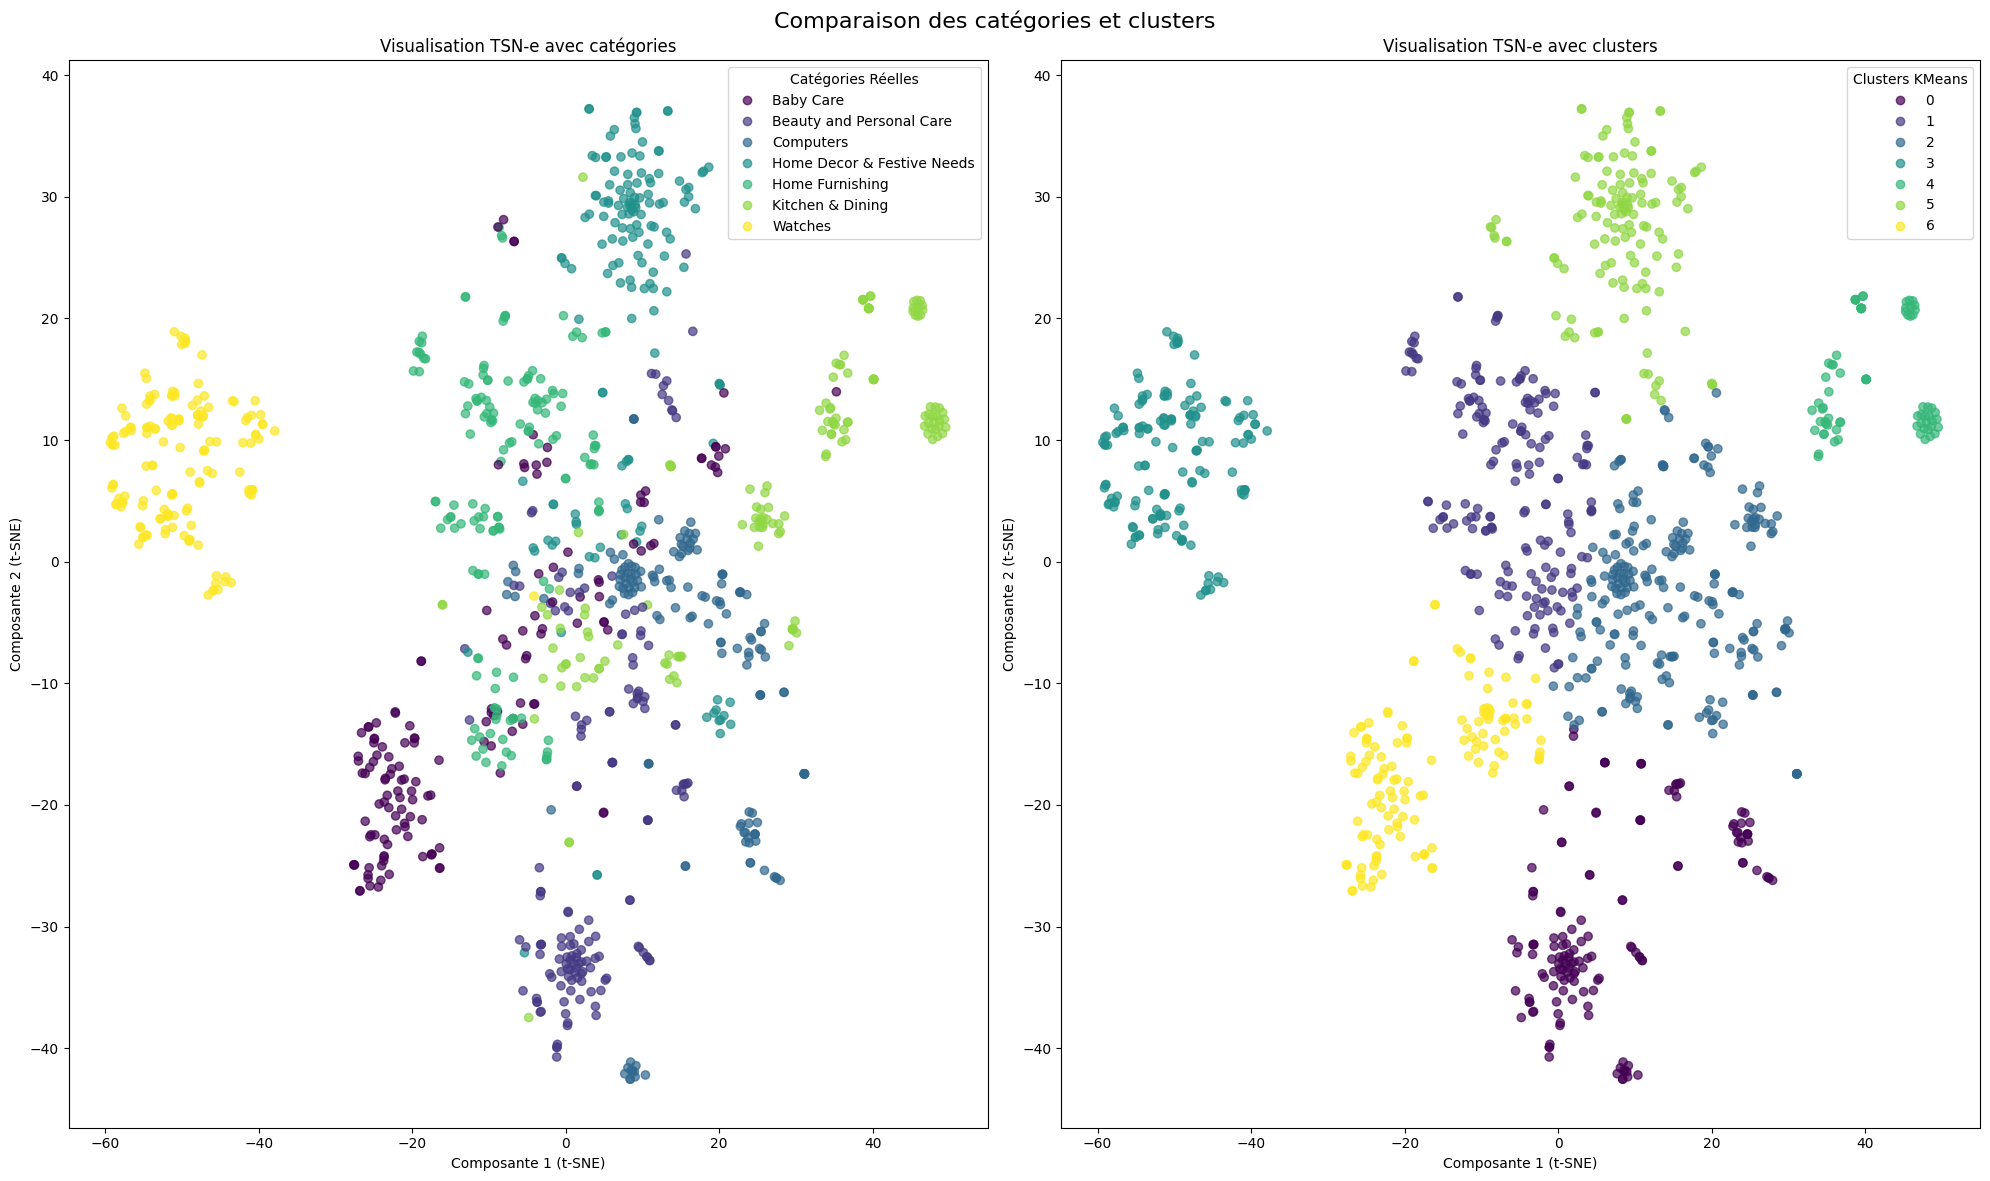

In [10]:
# Visualisation avec CountVectorizer
plot_result(count_matrix)

ARI : 0.46


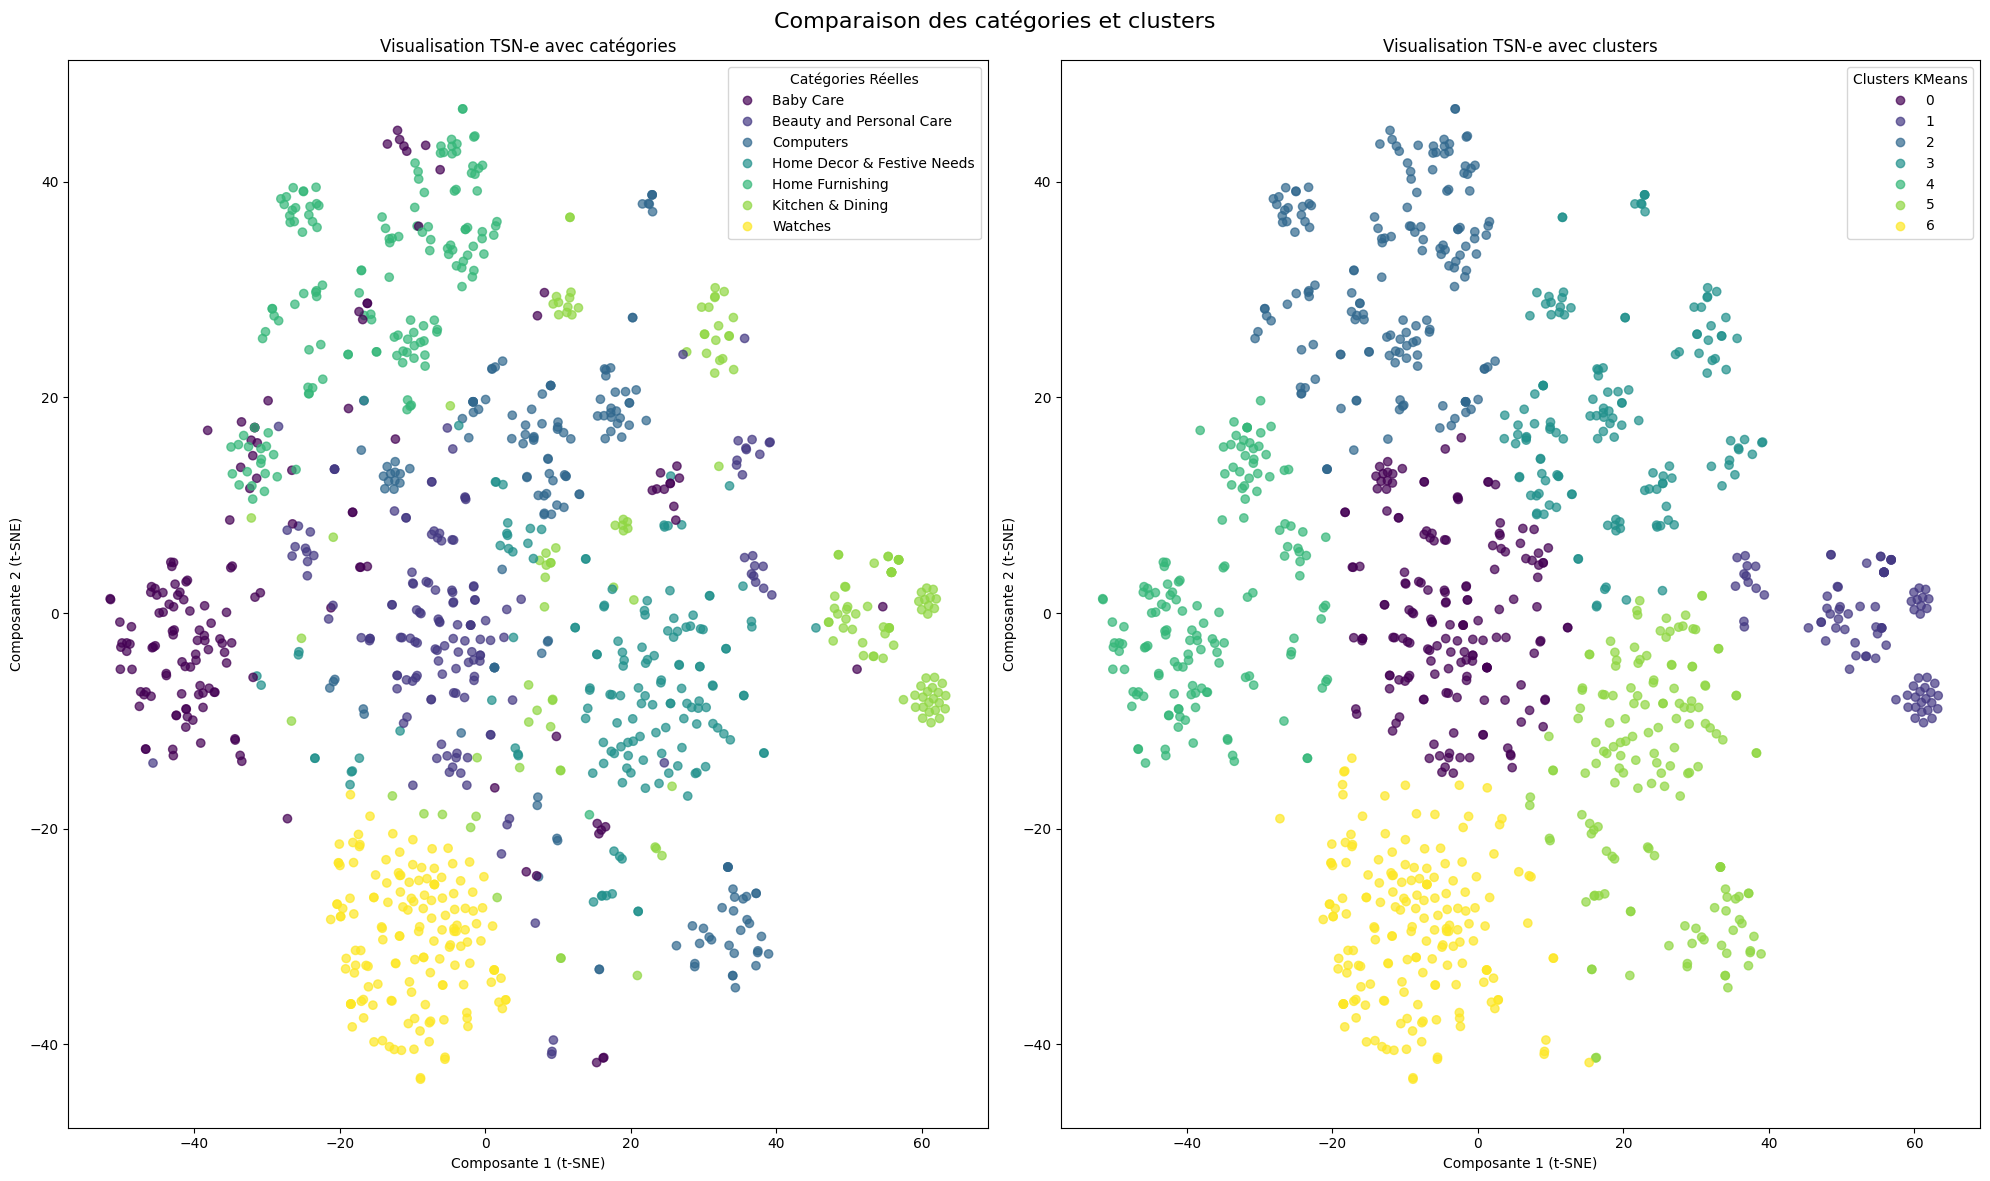

In [ ]:
# Visualisation avec Tf-idf
plot_result(tfidf_matrix)

### 2.4.3. <a id='toc2_4_3_'></a>[Analyse des résultats de clustering](#toc0_)
Les visualisations ci-dessus montrent les résultats du clustering KMeans appliqué sur les représentations en CountVectorizer et Tf-idf. Avec un ARI de 0,46 pour les deux méthodes, nous observons une correspondance modérée entre les clusters formés et les catégories réelles. Cela suggère que bien que les techniques de vectorisation permettent de regrouper certains produits similaires, la segmentation reste imparfaite, et des confusions subsistent entre certaines catégories.

Cette première analyse nous donne une base pour évaluer les méthodes de vectorisation de texte. Dans la suite, nous testerons des méthodes d'embedding plus avancées pour améliorer potentiellement la qualité du regroupement.

### 2.4.4. <a id='toc2_4_4_'></a>[Exploration des Méthodes d'Embeddings Avancées](#toc0_)

Après avoir obtenu des résultats intéressants avec **CountVectorizer** et **Tf-idf**, nous allons explorer des méthodes plus avancées pour capturer la sémantique des descriptions de produits. Nous allons utiliser :
- **Word2Vec** : Un modèle de langage qui apprend des représentations vectorielles des mots basées sur leur contexte.
- **BERT** : Un modèle de langage bidirectionnel pré-entraîné, conçu pour comprendre des relations complexes dans le texte.
- **Universal Sentence Encoder (USE)** : Un modèle qui produit des embeddings de phrases, capturant la signification des phrases entières.

Ces méthodes permettront de comparer les performances du clustering sur des embeddings plus sophistiqués, potentiellement mieux adaptés aux descriptions complexes des produits.
Nous espérons qu'en capturant des relations sémantiques plus riches, ces embeddings aideront à améliorer la précision du clustering, et donc la faisabilité de la classification automatique des produits sur la marketplace.

## 2.5. <a id='toc2_5_'></a>[Utilisation de Word2Vec](#toc0_)

Nous allons entraîner un modèle **Word2Vec** sur les descriptions de produits pour apprendre des représentations vectorielles des mots basées sur leur contexte. Chaque description de produit sera représentée par la moyenne des embeddings des mots qui la composent. 

Une fois les embeddings générés, nous appliquerons les mêmes techniques de réduction de dimension (PCA, t-SNE) et de clustering (KMeans) que précédemment pour visualiser et analyser les résultats.

In [12]:
# Préparation des données pour Word2Vec
descriptions['tokenized_description'] = descriptions['cleaned_description'].apply(lambda x: x.split())

In [ ]:
# Entraînement du modèle Word2Vec
word2vec_model = Word2Vec(sentences=descriptions['tokenized_description'])

### 2.5.1. <a id='toc2_5_1_'></a>[Génération des embeddings des descriptions de produits](#toc0_)
La fonction `get_embedding` calcule l'embedding moyen pour chaque description de produit en utilisant les vecteurs appris par Word2Vec. Pour chaque liste de mots (ou tokens), elle extrait les vecteurs correspondants et en calcule la moyenne, permettant ainsi de représenter chaque description de manière compacte et sémantiquement riche. Si aucun des mots n'est trouvé dans le modèle, un vecteur nul est renvoyé.

Cette fonction est ensuite appliquée à chaque description pour générer un vecteur d'embedding unique par produit.

In [14]:
def get_embedding(tokens):
    """
    Calcule l'embedding moyen pour une liste de tokens avec Word2Vec.

    Args:
        tokens (list): Liste de mots.

    Returns:
        np.ndarray: Vecteur moyen des embeddings des tokens présents dans le modèle, 
        ou un vecteur nul si aucun token n'est trouvé.
    """
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

# Appliquer cette fonction pour chaque description
descriptions['embedding'] = descriptions['tokenized_description'].apply(get_embedding)

ARI : 0.2


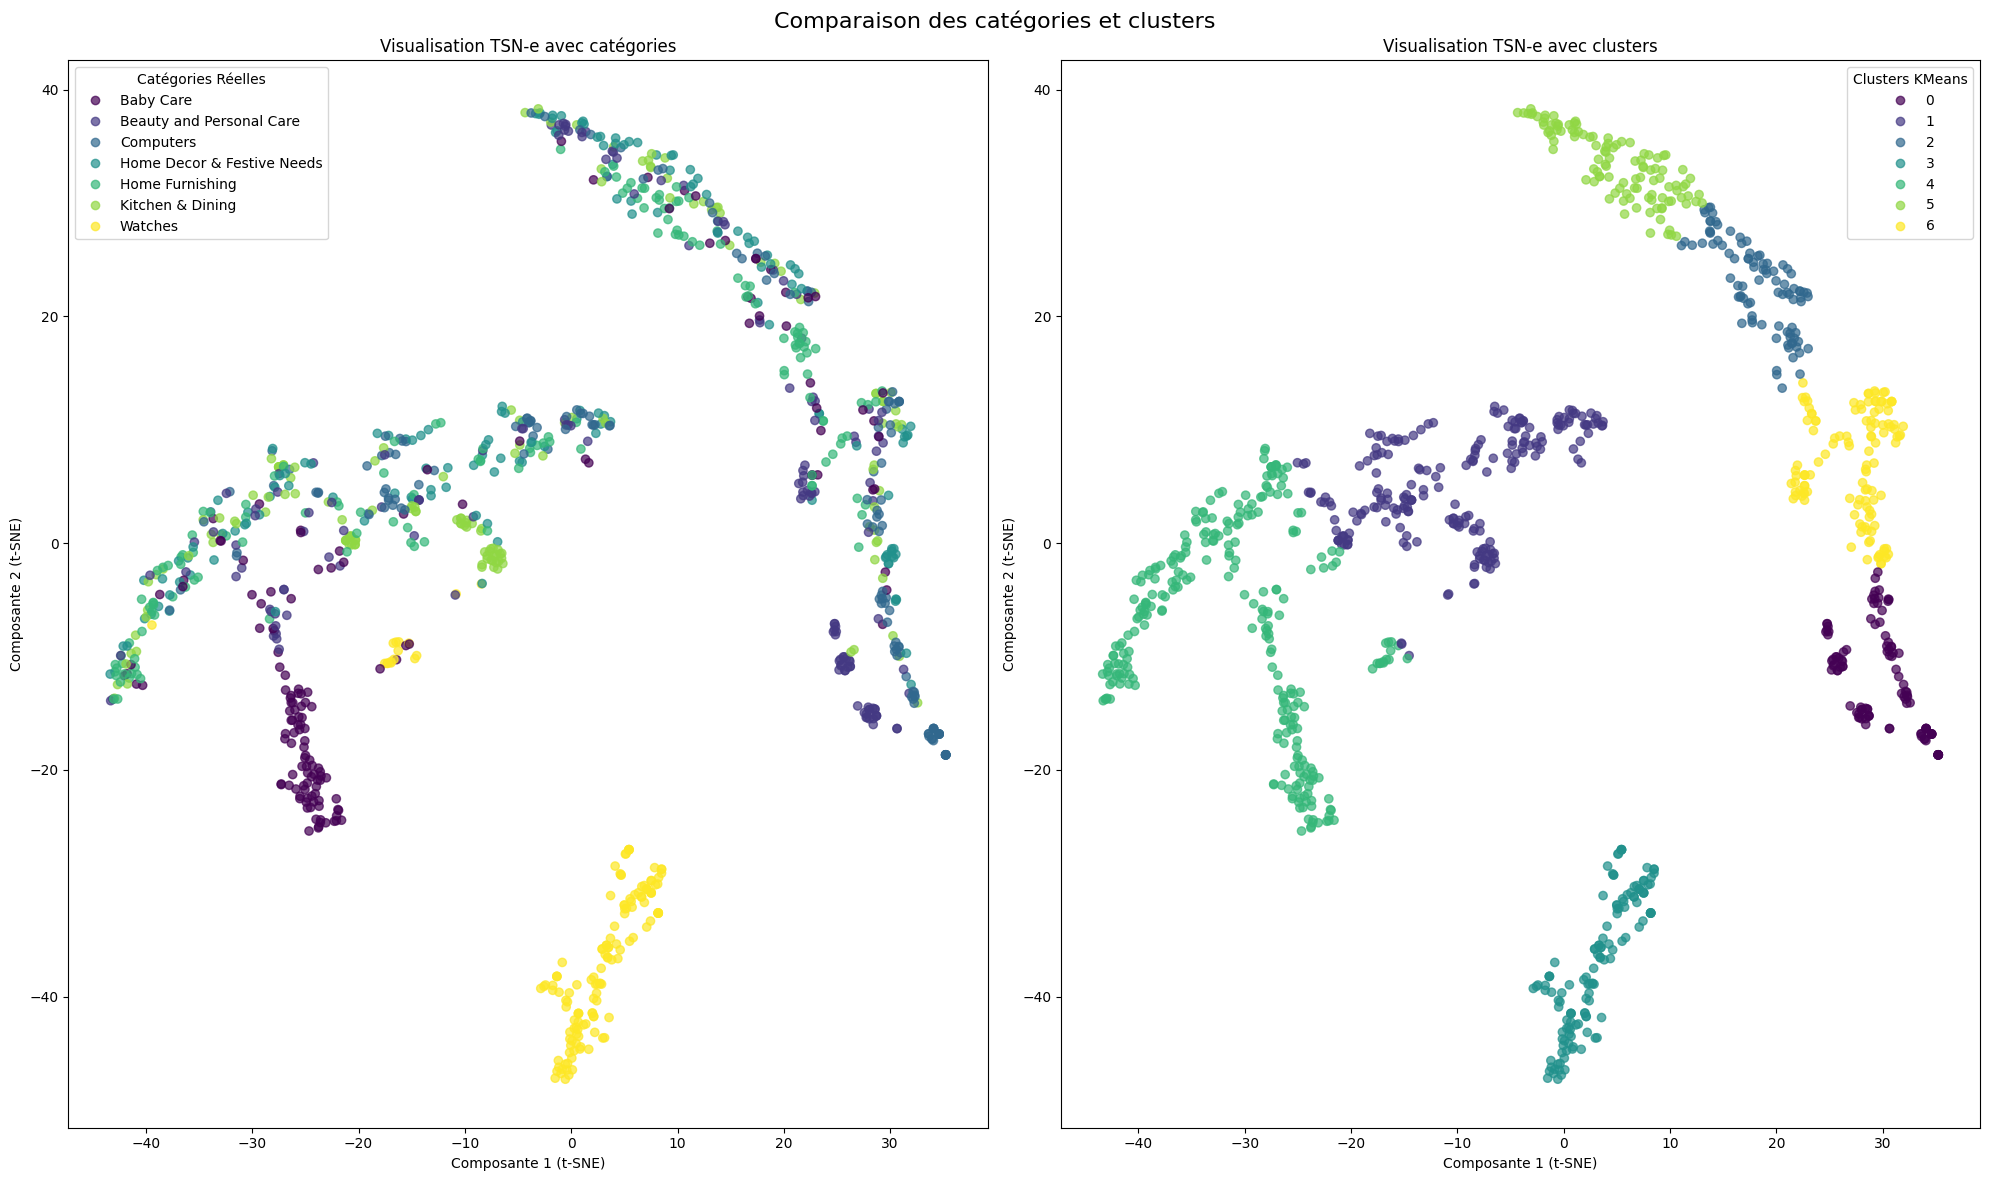

In [ ]:
# Conversion des embeddings en matrice pour pouvoir appliquer les techniques de réduction de dimension et clustering
embedding_matrix = np.vstack(descriptions['embedding'].values)

# Réutiliser la fonction plot_result avec les embeddings Word2Vec
plot_result(embedding_matrix)

### 2.5.2. <a id='toc2_5_2_'></a>[Analyse des résultats avec les embeddings Word2Vec](#toc0_)
Les graphiques ci-dessus montrent les résultats du clustering KMeans appliqué aux embeddings Word2Vec. Avec un ARI de 0,2, la correspondance entre les clusters et les catégories réelles est plus faible que celle obtenue avec les méthodes de vectorisation basiques (CountVectorizer et TfidfVectorizer).

Cette diminution de l'ARI suggère que, bien que Word2Vec capture des relations contextuelles entre les mots, les embeddings générés ne sont pas suffisamment discriminants pour séparer efficacement les catégories de produits dans cette configuration.

Dans la suite, nous explorerons des méthodes d'embeddings encore plus avancées, comme BERT et USE, pour voir si elles peuvent mieux représenter la sémantique des descriptions et améliorer les performances de clustering.

## 2.6. <a id='toc2_6_'></a>[Utilisation de BERT](#toc0_)

Nous allons utiliser un modèle pré-entraîné **BERT** de Hugging Face pour obtenir des embeddings des descriptions de produits. BERT, étant bidirectionnel, est capable de capturer des relations contextuelles plus complexes entre les mots, ce qui pourrait améliorer les résultats du clustering.

Comme pour les autres méthodes, nous allons réduire la dimensionnalité des embeddings obtenus avec **PCA** et **t-SNE**, et appliquer le clustering avec **KMeans**.

In [ ]:
# Charger le tokenizer et le modèle pré-entraîné BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

### 2.6.1. <a id='toc2_6_1_'></a>[Génération des embeddings des descriptions avec BERT](#toc0_)
La fonction `get_bert_embedding` utilise le modèle BERT pour générer un vecteur d'embedding pour chaque description de produit. Elle convertit le texte en tokens, puis récupère la dernière couche cachée de BERT et en calcule la moyenne pour obtenir un vecteur unique par description. Cette approche permet de capturer des informations contextuelles complexes dans chaque description, grâce à la capacité de BERT à analyser les relations bidirectionnelles entre les mots.

In [ ]:
def get_bert_embedding(text):
    """
    Calcule l'embedding d'une séquence textuelle à partir de BERT.

    Args:
        text (str): La description textuelle à convertir en embedding.

    Returns:
        np.ndarray: Vecteur d'embedding obtenu à partir de la dernière couche cachée 
        de BERT, moyenné sur les tokens de la séquence.
    """
    # Tokenizer la description et créer les tokens tensor
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Obtenir les embeddings avec le modèle BERT
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Utiliser la dernière couche cachée de BERT (outputs.last_hidden_state)
    last_hidden_states = outputs.last_hidden_state
    # Calculer la moyenne des embeddings sur les tokens de la séquence
    embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()

    return embedding

In [18]:
# Générer les embeddings BERT pour chaque description
descriptions['bert_embedding'] = descriptions['cleaned_description'].apply(get_bert_embedding)

ARI : 0.29


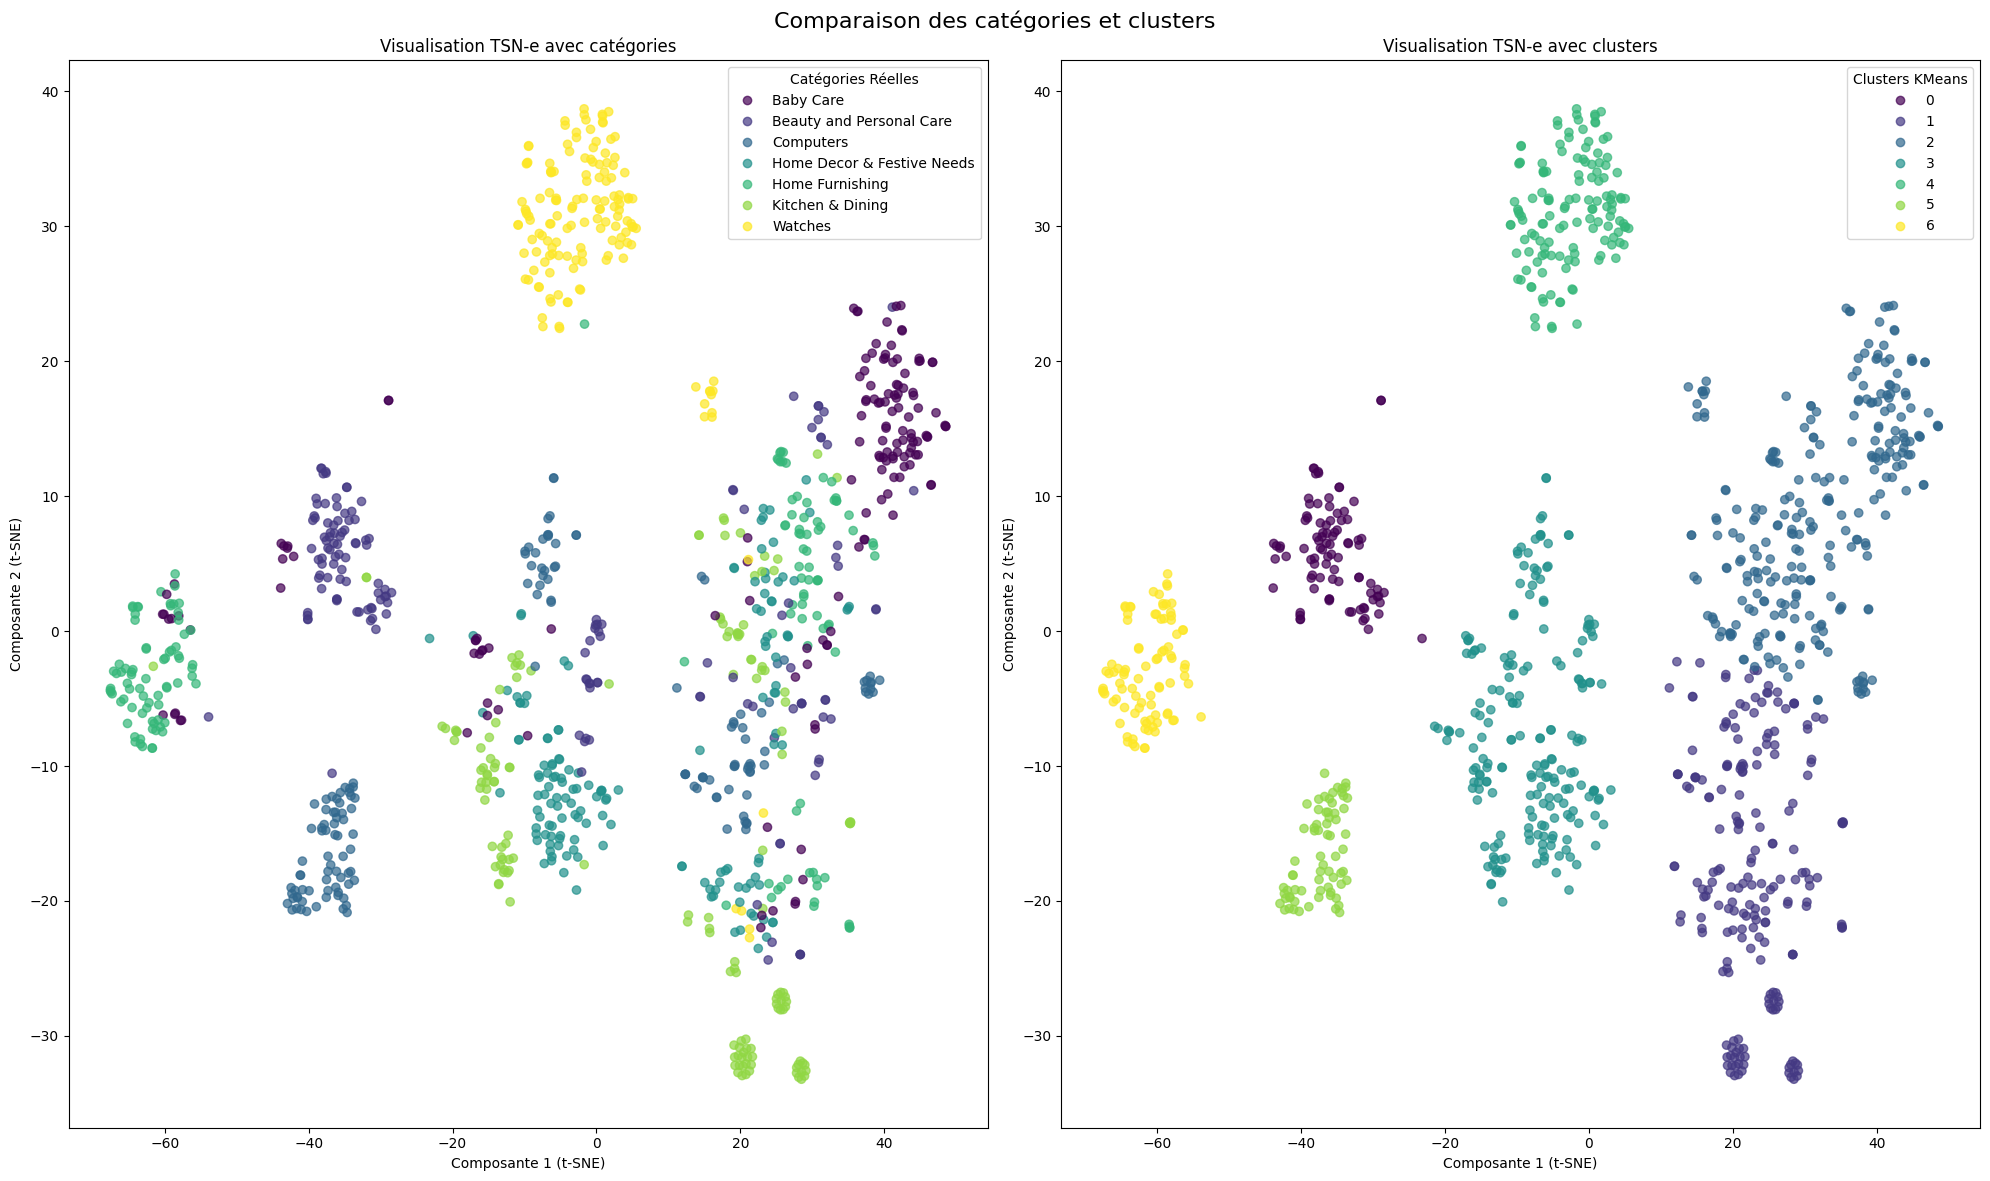

In [ ]:
# Conversion des embeddings en matrice
bert_embedding_matrix = np.vstack(descriptions['bert_embedding'].values)

# Réutiliser la fonction plot_result avec les embeddings BERT
plot_result(bert_embedding_matrix)

### 2.6.2. <a id='toc2_6_2_'></a>[Analyse visuelle et quantitative des résultats avec les embeddings BERT](#toc0_)
Les graphiques montrent des clusters modérément denses, mais on observe encore des zones de chevauchement entre certaines catégories, notamment entre les catégories *Home Furnishing* et *Kitchen & Dining*. Cette observation concorde avec l'ARI de 0,29, indiquant une légère amélioration par rapport à Word2Vec.

Cependant, certaines catégories comme *Watches* apparaissent bien isolées visuellement, ce qui pourrait indiquer que BERT parvient mieux à capturer des informations spécifiques pour ces produits. L’approche BERT semble donc permettre une séparation plus cohérente pour certaines catégories, mais des confusions subsistent pour d'autres.

Nous allons explorer USE pour voir si cette méthode peut réduire davantage ces chevauchements entre clusters.

## 2.7. <a id='toc2_7_'></a>[Utilisation de Universal Sentence Encoder (USE)](#toc0_)

Nous allons maintenant utiliser **Universal Sentence Encoder (USE)**, un modèle qui produit des embeddings de phrases entières. Ce modèle est conçu pour capturer la signification globale d'une phrase, ce qui le rend particulièrement utile pour des descriptions de produits complètes.

Nous appliquerons ensuite les mêmes techniques de réduction de dimension et de clustering afin de comparer les résultats avec les autres méthodes.

In [ ]:
# Charger le modèle avec une URL stable
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

### 2.7.1. <a id='toc2_7_1_'></a>[Génération des embeddings des descriptions avec USE](#toc0_)
La fonction `get_use_embedding` utilise le modèle Universal Sentence Encoder (USE) pour générer un vecteur d'embedding pour chaque description de produit. En passant le texte dans le modèle, nous obtenons un vecteur qui capture la signification globale de la phrase, ce qui est particulièrement utile pour des descriptions complètes de produits.

In [21]:
# Fonction pour obtenir l'embedding USE d'une description
def get_use_embedding(text):
    """
    Calcule l'embedding d'une séquence textuelle à partir du modèle Universal Sentence Encoder (USE).

    Args:
        text (str): La description textuelle à convertir en embedding.

    Returns:
        np.ndarray: Vecteur d'embedding de la phrase obtenu à partir de USE.
    """
    # Passer la description dans le modèle USE pour obtenir l'embedding
    embedding = use_model([text])
    return embedding.numpy().squeeze()

In [22]:
# Générer les embeddings USE pour chaque description
descriptions['use_embedding'] = descriptions['cleaned_description'].apply(get_use_embedding)

ARI : 0.46


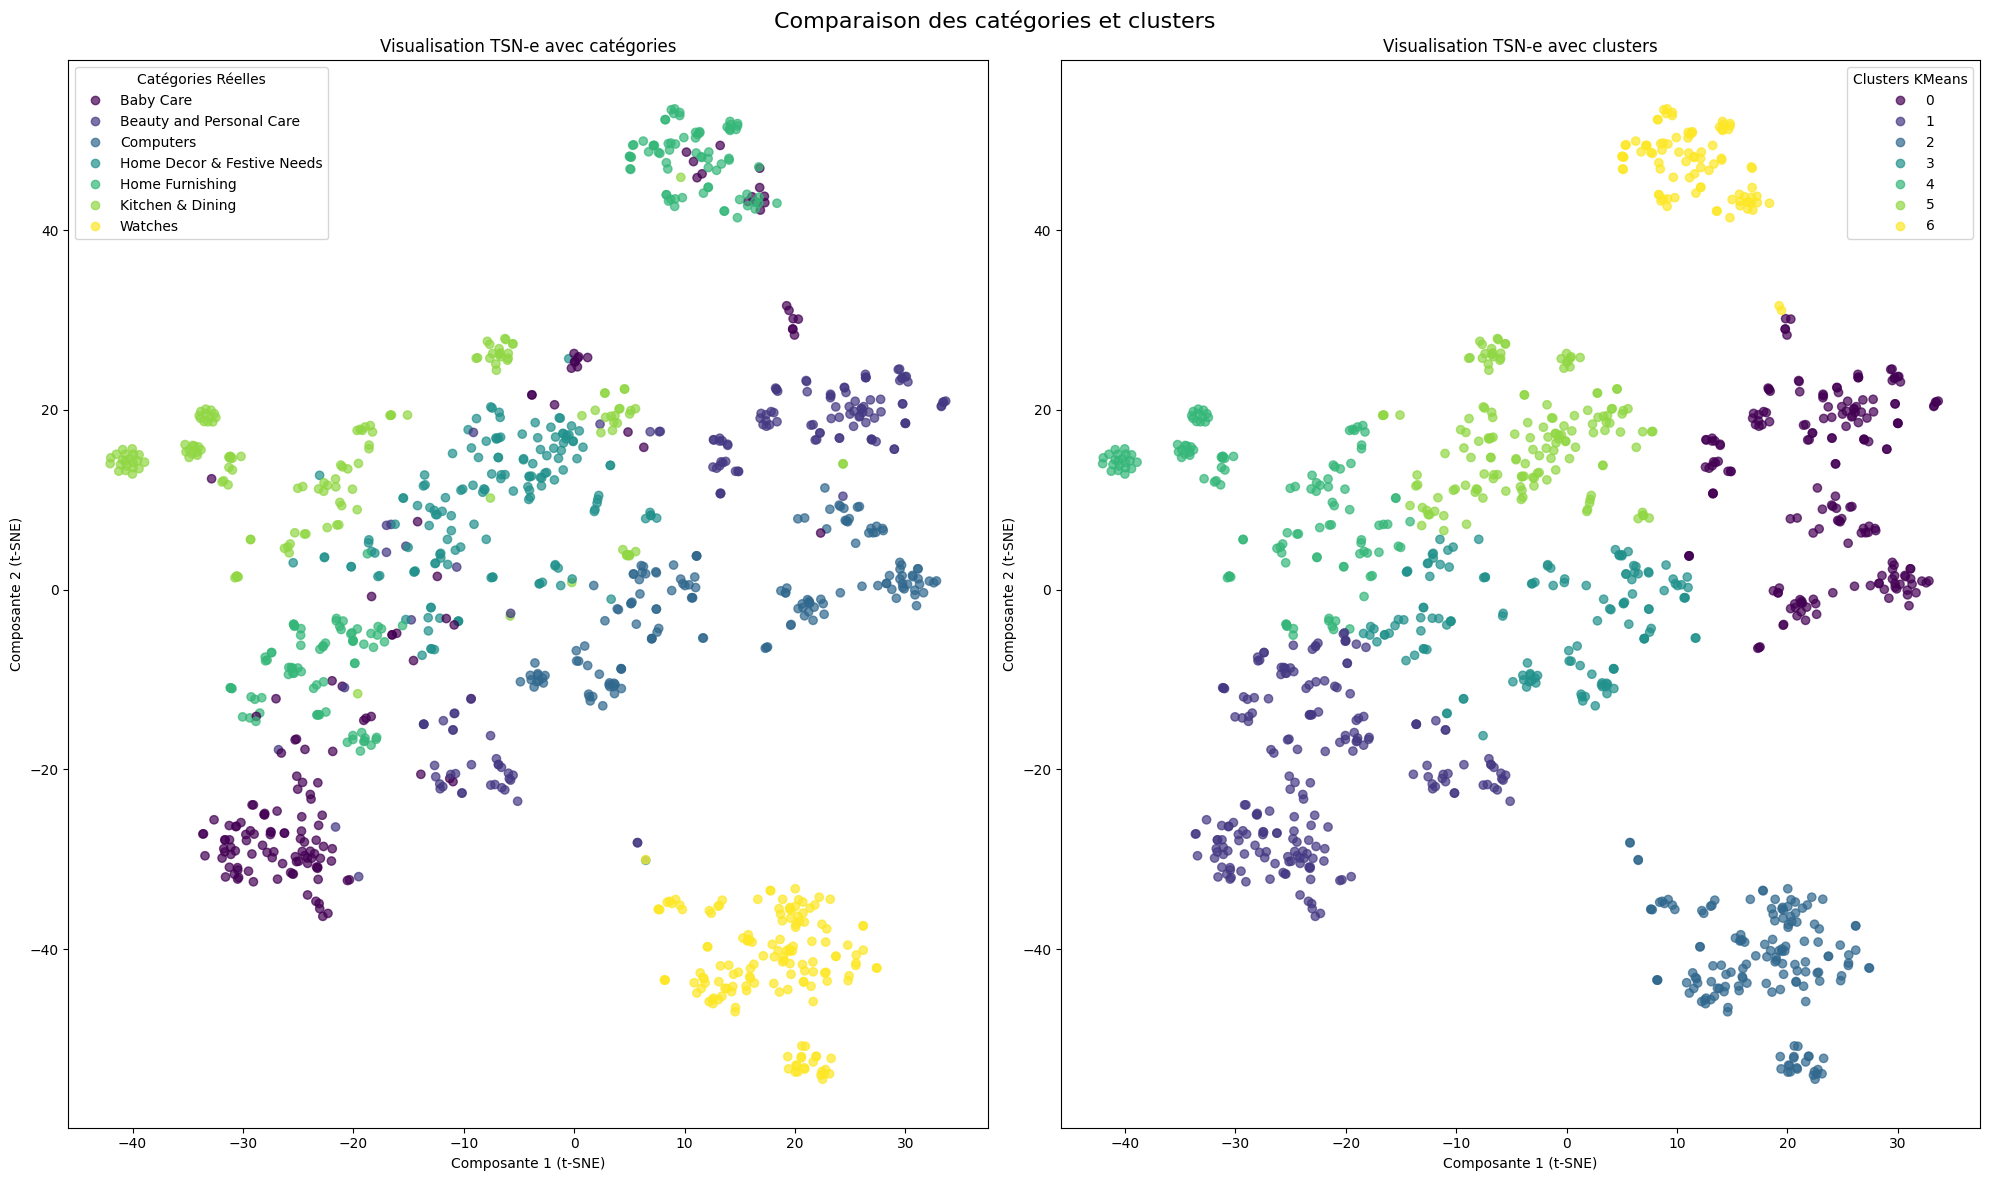

In [ ]:
# Conversion des embeddings en matrice
use_embedding_matrix = np.vstack(descriptions['use_embedding'].values)

# Réutiliser plot_result pour visualiser les résultats avec USE
plot_result(use_embedding_matrix)

### 2.7.2. <a id='toc2_7_2_'></a>[Analyse des résultats avec les embeddings USE](#toc0_)
Les graphiques ci-dessus montrent les résultats du clustering KMeans appliqué aux embeddings obtenus avec Universal Sentence Encoder (USE). Avec un ARI de 0,46, cette méthode atteint le même score que les vectorisations de base (CountVectorizer et TF-IDF), indiquant une correspondance modérée entre les clusters et les catégories réelles.

Visuellement, les clusters semblent bien définis pour certaines catégories, comme *Watches* et *Kitchen & Dining*, tandis que d’autres présentent encore des chevauchements. L'approche USE parvient ainsi à capturer des structures sémantiques plus globales dans les descriptions, permettant une séparation plus nette pour certaines catégories, mais laissant subsister des ambiguïtés pour d'autres.

Ces résultats suggèrent que USE est efficace pour représenter la sémantique globale des descriptions, mais que certaines limitations demeurent pour des catégories plus complexes.

In [ ]:
# Données pour le DataFrame
text_methods = {
    'Méthode': ['CountVectorizer', 'Tf-idf', 'Word2Vec', 'BERT', 'USE'],
    'ARI': [0.46, 0.46, 0.2, 0.29, 0.46]
}

# Création et affichage du DataFrame
df_text_methods = pd.DataFrame(text_methods)
df_text_methods

Méthode   ARI
0  CountVectorizer  0.46
1           Tf-idf  0.46
2         Word2Vec  0.20
3             BERT  0.29
4              USE  0.46

### 2.7.3. <a id='toc2_7_3_'></a>[Conclusion intermédiaire et transition vers l'analyse des images](#toc0_)
Dans cette première partie, nous avons exploré différentes méthodes de vectorisation et d’embedding (CountVectorizer, Tf-idf, Word2Vec, BERT, et USE) pour évaluer la faisabilité d'une classification automatique des produits en fonction de leurs descriptions textuelles. Les méthodes traditionnelles de vectorisation (CountVectorizer et Tf-idf) et l’approche USE ont obtenu des scores d’ARI de 0,46, indiquant une correspondance modérée entre les clusters et les catégories réelles. Les embeddings avancés tels que Word2Vec et BERT, bien que performants pour capturer des relations contextuelles, n'ont pas apporté d’amélioration significative dans notre contexte, ce qui suggère que les descriptions de produits bénéficient davantage d’une représentation sémantique globale.

Ces résultats soulignent la pertinence de méthodes de vectorisation globale, comme USE, pour la classification des descriptions textuelles de produits. Cependant, pour une approche plus complète de la classification des articles, nous allons maintenant étudier les caractéristiques visuelles des produits en appliquant des méthodes de traitement d’image, notamment ORB pour l’extraction de descripteurs locaux, et VGG16, un modèle de réseau de neurones profond pré-entraîné.

L’intégration des données textuelles et visuelles dans un modèle de classification pourrait offrir une meilleure compréhension globale des produits, permettant ainsi une catégorisation plus précise et robuste.

# 3. <a id='toc3_'></a>[Analyse Visuelle](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Analyse des caractéristiques visuelles des produits](#toc0_)
Dans cette deuxième partie, nous allons explorer les caractéristiques visuelles des produits pour enrichir notre approche de classification. En complément des descriptions textuelles, les images peuvent fournir des informations uniques et permettre de mieux différencier les catégories de produits. Nous commencerons par utiliser ORB (Oriented FAST and Rotated BRIEF) pour extraire des descripteurs locaux des images, puis nous exploiterons un modèle de deep learning pré-entraîné, VGG16, pour obtenir des embeddings visuels plus complexes.

L’objectif est d’analyser si les caractéristiques visuelles des produits permettent d’obtenir une bonne séparation des catégories et de tester la faisabilité d’une classification basée uniquement sur les informations visuelles.

### 3.1.1. <a id='toc3_1_1_'></a>[Chargement des images](#toc0_)
Dans cette étape, nous préparons les données visuelles en listant les chemins des images disponibles. En parcourant le fichier CSV contenant les noms d'images, nous vérifions l'existence de chaque fichier image dans le dossier `images` avant de l'ajouter à notre liste. Cela garantit que seules les images valides seront utilisées pour l'extraction de caractéristiques.

In [ ]:
# Dossier contenant les images
image_folder = 'images'

# Liste pour stocker les chemins des images
image_paths = []

# Parcourir les noms d'images depuis le CSV
for _, row in data.iterrows():  # Utilise le fichier CSV déjà chargé au début du notebook
    img_name = row['image']  # La colonne 'image' contient le nom de l'image
    img_path = os.path.join(image_folder, img_name)

    # Vérifier si l'image existe avant de l'ajouter à la liste
    if os.path.exists(img_path):
        image_paths.append(img_path)

# Vérification
print(f"Nombre d'images chargées : {len(image_paths)}")

Nombre d'images chargées : 1050


### 3.1.2. <a id='toc3_1_2_'></a>[Extraction des descripteurs ORB](#toc0_)
Nous utilisons l'algorithme ORB (Oriented FAST and Rotated BRIEF) pour extraire des descripteurs visuels de chaque image. Pour chaque image en niveaux de gris, nous détectons des points clés et calculons les descripteurs correspondants. Seules les images pour lesquelles des descripteurs sont extraits avec succès sont ajoutées à notre liste de données valides. Cette étape garantit que nous disposons de caractéristiques visuelles exploitables pour l'analyse et le clustering.

In [ ]:
# Initialiser ORB
orb = cv2.ORB_create()

# Listes pour stocker les chemins des images valides et les descripteurs ORB
valid_image_paths = []
orb_descriptors = []

# Parcourir et charger chaque image pour extraire les descripteurs
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Erreur de chargement de l'image : {img_path}")
        continue

    # Détecter les points clés et calculer les descripteurs
    keypoints, descriptors = orb.detectAndCompute(img, None)

    if descriptors is not None:
        valid_image_paths.append(img_path)
        orb_descriptors.append(descriptors)
    else:
        print(f"Pas de descripteurs trouvés pour l'image : {img_path}")

# Vérification
print(f"Nombre d'images valides avec descripteurs : {len(valid_image_paths)}")
print(f"Nombre total de descripteurs extraits : {len(orb_descriptors)}")

Pas de descripteurs trouvés pour l'image : images\9743e6d1c9f3180483825fe4d2e97836.jpg
Nombre d'images valides avec descripteurs : 1049
Nombre total de descripteurs extraits : 1049


### 3.1.3. <a id='toc3_1_3_'></a>[Synchronisation des données et transformation en Bag-of-Words pour ORB](#toc0_)
Pour assurer la cohérence entre les images, descripteurs et catégories, nous reconstruisons des listes strictement synchronisées, excluant les échantillons sans descripteurs valides. Cela garantit que chaque élément est correctement aligné pour l'analyse.

Ensuite, nous utilisons l'approche Bag-of-Words pour convertir les descripteurs ORB en histogrammes de caractéristiques. En appliquant un clustering KMeans avec 50 clusters sur l'ensemble des descripteurs, nous créons un "dictionnaire visuel" qui capture les motifs récurrents dans les images. Chaque image est alors représentée par un histogramme indiquant la fréquence des motifs détectés.

Enfin, les histogrammes sont convertis en un tableau `orb_features_concat` pour faciliter l'analyse et la visualisation ultérieure des données visuelles.

In [ ]:
# Reconstruction stricte des listes synchronisées
valid_image_paths = []
valid_descriptors = []
valid_categories = []

# Synchroniser en excluant les échantillons non alignés
for img_path, descriptors, category in zip(image_paths, orb_descriptors, categories):
    if descriptors is not None:
        valid_image_paths.append(img_path)
        valid_descriptors.append(descriptors)
        valid_categories.append(category)

# Conversion de `valid_categories` en pd.Series pour uniformiser le type
valid_categories = pd.Series(valid_categories).astype('category')

# Transformation des descripteurs en histogrammes Bag-of-Words
n_clusters = 50
all_descriptors = np.vstack(valid_descriptors)
kmeans_bow = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans_bow.fit(all_descriptors)

# Construire les histogrammes pour chaque image avec des descripteurs
image_histograms = []
for descriptors in valid_descriptors:
    labels = kmeans_bow.predict(descriptors)
    histogram, _ = np.histogram(labels, bins=np.arange(n_clusters + 1))
    image_histograms.append(histogram)

# Conversion finale en np.array pour visualisation
orb_features_concat = np.array(image_histograms)

# Validation stricte des longueurs finales avant toute visualisation
print(f"Taille de orb_features_concat : {len(orb_features_concat)}")
print(f"Taille de valid_categories : {len(valid_categories)}")

Taille de orb_features_concat : 1049
Taille de valid_categories : 1049


### 3.1.4. <a id='toc3_1_4_'></a>[Visualisation des caractéristiques ORB : réduction de dimension et clustering](#toc0_)
La fonction `visualize_features` permet de visualiser les caractéristiques extraites des images à l’aide d’ORB en appliquant plusieurs étapes d’analyse :

1. **Réduction de dimension** : PCA est utilisé pour réduire les dimensions des histogrammes de descripteurs ORB tout en conservant 99 % de la variance. Ensuite, t-SNE est appliqué pour projeter les données en 2D, facilitant la visualisation.

2. **Clustering** : KMeans est utilisé pour regrouper les images en `n_clusters` visuels. Cela permet de comparer les clusters obtenus aux catégories réelles (si elles sont disponibles) et d'évaluer la qualité de la séparation des groupes visuels.

3. **Évaluation de la performance** : Si les catégories réelles sont fournies, l'indice de Rand ajusté (ARI) est calculé pour quantifier la correspondance entre les clusters et les catégories réelles.

4. **Affichage des résultats** : Deux graphiques sont produits, l’un montrant la visualisation avec les catégories réelles, et l’autre affichant les clusters KMeans. Cette comparaison visuelle aide à évaluer la cohérence entre les groupes obtenus par clustering et les catégories de produits.

Cette fonction offre donc une vue d’ensemble des caractéristiques visuelles des produits, permettant d’apprécier la capacité des descripteurs ORB à discriminer entre différentes catégories.

In [ ]:
def visualize_features(features, categories=None, n_clusters=7, random_state=42):
    """
    Applique PCA et t-SNE pour réduire les dimensions des features, puis 
    effectue un clustering avec KMeans et affiche les résultats en deux sous-graphiques.

    Args:
        features (np.array): La matrice des histogrammes des descripteurs ORB.
        categories (pd.Series, optionnel): Les catégories réelles des images si disponible.
        n_clusters (int): Le nombre de clusters pour KMeans.
        random_state (int): L'état aléatoire pour la reproductibilité.
    """
    # Réduction de dimension avec PCA pour conserver 99 % de la variance
    pca = PCA(n_components=0.99)
    matrix_pca = pca.fit_transform(features)

    # Réduction avec t-SNE pour visualiser en 2D
    tsne = TSNE(n_components=2, random_state=random_state)
    matrix_tsne = tsne.fit_transform(matrix_pca)

    # Clustering KMeans pour les clusters visuels
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(matrix_tsne)

    # Calcul de l'ARI si les catégories sont disponibles
    if categories is not None:
        ari = adjusted_rand_score(categories.cat.codes, kmeans_labels)
        print(f"ARI : {np.round(ari, 2)}")

    # Affichage des résultats : Catégories réelles vs Clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    fig.suptitle('Comparaison des catégories et clusters', fontsize=16)

    # Visualisation des catégories réelles
    if categories is not None:
        scatter1 = ax1.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1],
                               c=categories.cat.codes, cmap='viridis', alpha=0.7)
        # Légende des vraies catégories
        handles, labels = scatter1.legend_elements()
        ax1.legend(handles, categories.cat.categories, title="Catégories Réelles")
    else:
        ax1.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1], alpha=0.7)

    ax1.set_title('Visualisation t-SNE avec catégories' if categories is not None else 'Visualisation t-SNE')
    ax1.set_xlabel('Composante 1 (t-SNE)')
    ax1.set_ylabel('Composante 2 (t-SNE)')

    # Visualisation des clusters KMeans
    scatter2 = ax2.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1],
                           c=kmeans_labels, cmap='viridis', alpha=0.7)

    ax2.set_title('Visualisation t-SNE avec clusters')
    ax2.set_xlabel('Composante 1 (t-SNE)')
    ax2.set_ylabel('Composante 2 (t-SNE)')

    # Légende pour les clusters
    handles2, labels2 = scatter2.legend_elements()
    ax2.legend(handles2, labels2, title="Clusters KMeans")

    plt.tight_layout()
    plt.show()

Les longueurs sont synchronisées. Prêt pour la visualisation.
ARI : 0.02


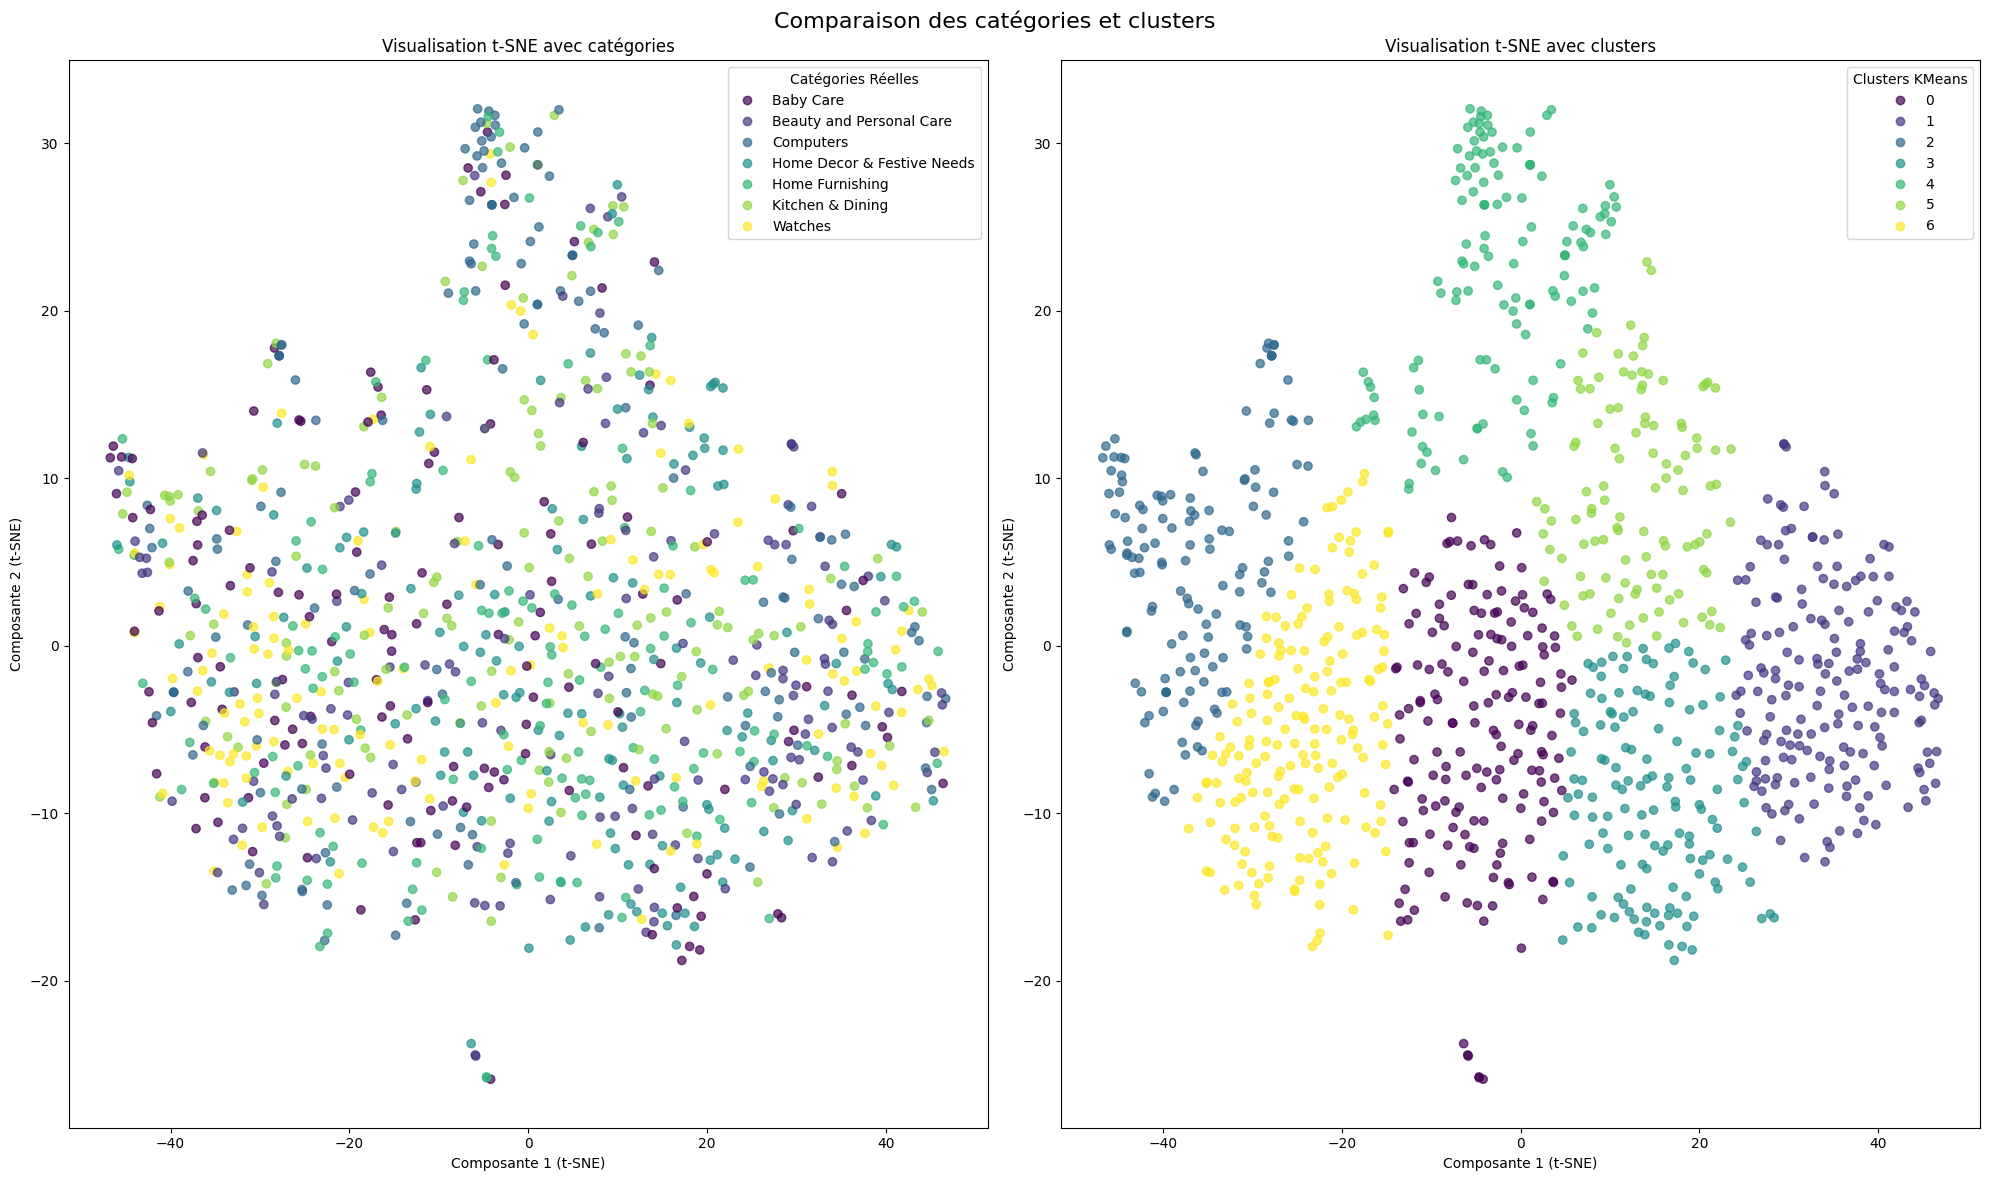

In [ ]:
# Appliquer la visualisation seulement si les longueurs sont cohérentes
if len(orb_features_concat) == len(valid_categories):
    print("Les longueurs sont synchronisées. Prêt pour la visualisation.")
    visualize_features(orb_features_concat, categories=valid_categories)
else:
    print("Incohérence détectée après la synchronisation stricte. Ajustement nécessaire.")

### 3.1.5. <a id='toc3_1_5_'></a>[Analyse des résultats avec les descripteurs ORB et le clustering KMeans](#toc0_)
Les graphiques ci-dessus présentent les résultats du clustering KMeans appliqué aux histogrammes Bag-of-Words construits à partir des descripteurs ORB. L'indice de Rand ajusté (ARI) est très faible (0,02), indiquant une correspondance presque inexistante entre les clusters obtenus et les catégories réelles.

Visuellement, les clusters sont dispersés et les catégories semblent s'entremêler, sans séparation claire. Cela suggère que les descripteurs ORB, bien qu’efficaces pour capter des détails locaux dans les images, ne parviennent pas ici à représenter des caractéristiques suffisamment discriminantes pour permettre une classification précise des produits par catégorie.

Ces résultats mettent en évidence les limites de l'approche ORB pour cette tâche, et confirment l'intérêt d'explorer des méthodes plus avancées de représentation visuelle, comme les modèles de réseaux de neurones profonds (ex. : VGG16), qui peuvent capturer des caractéristiques visuelles plus globales et complexes.

## 3.2. <a id='toc3_2_'></a>[Utilisation de VGG16 pour l'extraction de caractéristiques visuelles](#toc0_)
Pour dépasser les limites des descripteurs ORB, nous allons utiliser un modèle de réseau de neurones profond pré-entraîné, **VGG16**. Ce modèle, développé pour la classification d'images sur l'ensemble de données ImageNet, est capable de capturer des caractéristiques visuelles complexes et globales. En supprimant sa dernière couche de classification, nous utilisons VGG16 comme un extracteur de features, en exploitant les couches convolutionnelles pour obtenir une représentation riche et discriminante de chaque image. Cette approche devrait améliorer notre capacité à regrouper les images par catégories.

### 3.2.1. <a id='toc3_2_1_'></a>[Extraction des caractéristiques avec VGG16](#toc0_)
Le code suivant initialise VGG16 sans sa dernière couche et définit une fonction pour extraire les caractéristiques de chaque image dans `image_paths`. Pour chaque image :
- Nous chargeons l'image et la redimensionnons à 224x224 pixels, taille d'entrée requise par VGG16.
- L'image est ensuite prétraitée pour s'adapter aux exigences du modèle VGG16 (normalisation).
- Les caractéristiques visuelles sont extraites en passant l'image dans le modèle, puis converties en vecteur 1D pour être utilisées dans les étapes suivantes de clustering et de visualisation.

In [ ]:
# Charger VGG16 sans la dernière couche (couche de classification)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fonction pour extraire les features avec VGG16
def extract_vgg16_features(image_paths):
    features = []
    for img_path in image_paths:
        try:
            # Charger et prétraiter l'image
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Extraire les features avec VGG16
            feature = vgg16_model.predict(img_array)
            features.append(feature.flatten())  # Convertir en vecteur 1D
        except Exception as e:
            print(f"Erreur pour l'image {img_path} : {e}")

    return np.array(features)

### 3.2.2. <a id='toc3_2_2_'></a>[Extraction des caractéristiques avec VGG16](#toc0_)
Nous utilisons la fonction `extract_vgg16_features` pour traiter les images valides et obtenir leurs vecteurs de caractéristiques. Cette étape nous fournit des représentations visuelles riches pour chaque image, prêtes pour les étapes de réduction de dimension et de clustering.

In [ ]:
# Extraire les features des images valides
vgg16_features = extract_vgg16_features(valid_image_paths)
print(f"Nombre d'images traitées avec VGG16 : {len(vgg16_features)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

### 3.2.3. <a id='toc3_2_3_'></a>[Réduction de dimension, clustering et visualisation des caractéristiques VGG16](#toc0_)
Dans cette étape, nous appliquons plusieurs techniques d'analyse pour étudier la répartition des images en fonction des caractéristiques extraites par VGG16 :

1. **Réduction de dimension** : Nous utilisons PCA pour réduire les dimensions des caractéristiques VGG16 tout en conservant 99 % de la variance. Ensuite, t-SNE est appliqué pour projeter les données en 2D, facilitant ainsi la visualisation.

2. **Clustering** : KMeans est utilisé pour regrouper les images en 7 clusters (correspondant au nombre de catégories de produits). Le nombre de clusters peut être ajusté en fonction des besoins spécifiques de la classification.

3. **Évaluation de la performance** : Si les catégories réelles sont disponibles, l'indice de Rand ajusté (ARI) est calculé pour quantifier la correspondance entre les clusters obtenus et les catégories réelles.

4. **Visualisation des résultats** : Deux graphiques sont produits, l'un montrant la visualisation avec les catégories réelles, et l'autre affichant les clusters KMeans. Cette comparaison visuelle permet d'évaluer la qualité des regroupements et de voir si les caractéristiques extraites par VGG16 aident à séparer correctement les catégories de produits.

ARI : 0.3


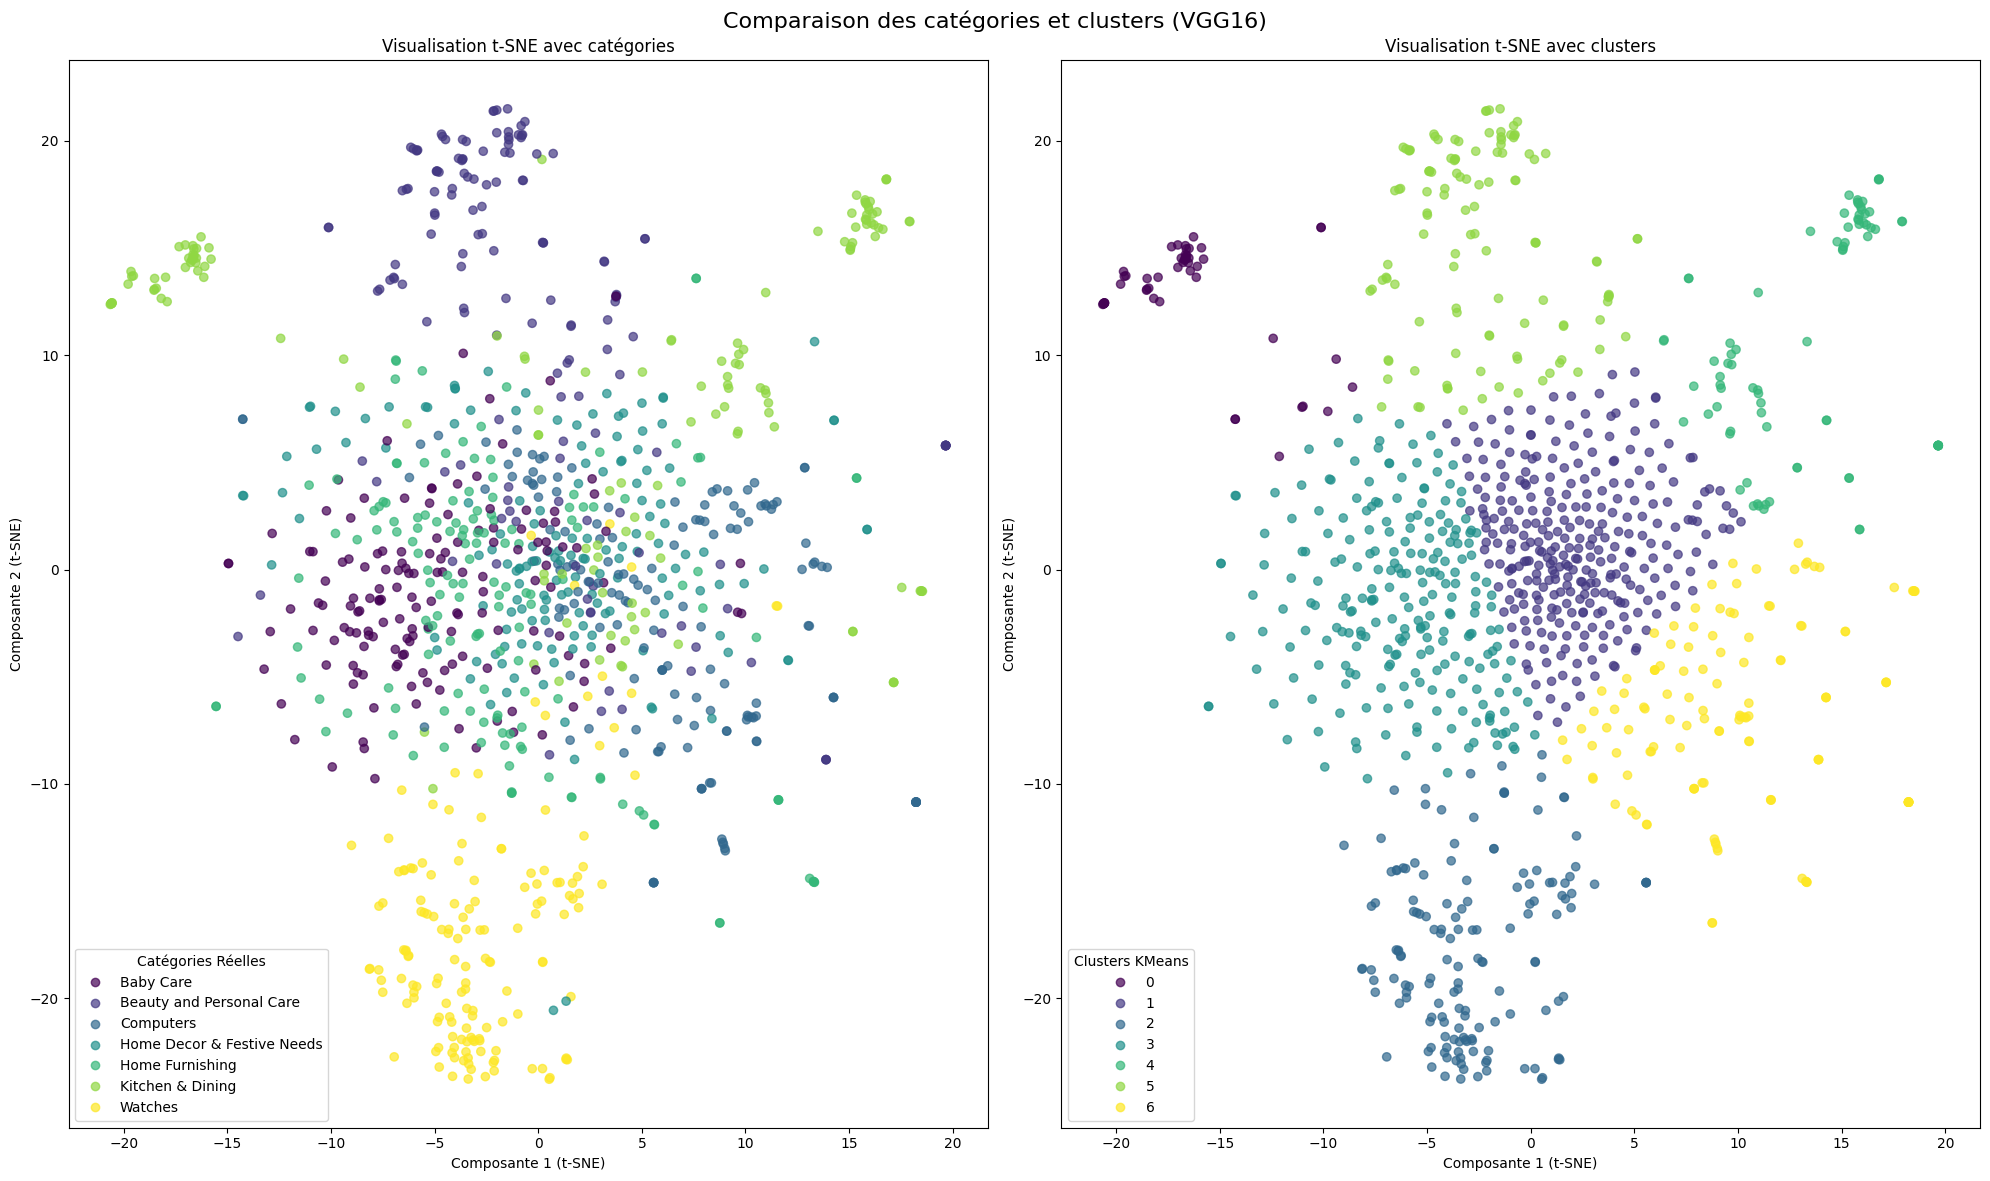

In [69]:
# Réduction de dimension avec PCA et t-SNE
pca = PCA(n_components=0.99)
pca_features = pca.fit_transform(vgg16_features)
tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Clustering avec KMeans
n_clusters = 7  # Ajuste en fonction du nombre de catégories
kmeans = KMeans(n_clusters=n_clusters)
kmeans_labels = kmeans.fit_predict(tsne_features)

# Calculer l'ARI si les catégories sont disponibles
if valid_categories is not None:
    ari = adjusted_rand_score(valid_categories.cat.codes, kmeans_labels)
    print(f"ARI : {np.round(ari, 2)}")
else:
    print("Les catégories ne sont pas disponibles pour calculer l'ARI.")

# Visualisation des catégories et des clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
fig.suptitle('Comparaison des catégories et clusters (VGG16)', fontsize=16)

# Visualisation des catégories réelles
scatter1 = ax1.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                       c=valid_categories.cat.codes, cmap='viridis', alpha=0.7)
handles, labels = scatter1.legend_elements()
ax1.legend(handles, valid_categories.cat.categories, title="Catégories Réelles")
ax1.set_title('Visualisation t-SNE avec catégories')
ax1.set_xlabel('Composante 1 (t-SNE)')
ax1.set_ylabel('Composante 2 (t-SNE)')

# Visualisation des clusters KMeans
scatter2 = ax2.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                       c=kmeans_labels, cmap='viridis', alpha=0.7)

# Générer la légende automatiquement
handles2, labels2 = scatter2.legend_elements()
ax2.legend(handles=handles2, labels=labels2, title="Clusters KMeans")  # Corrige la syntaxe ici

ax2.set_title('Visualisation t-SNE avec clusters')
ax2.set_xlabel('Composante 1 (t-SNE)')
ax2.set_ylabel('Composante 2 (t-SNE)')

plt.tight_layout()
plt.show()

In [ ]:
# Données pour le DataFrame
image_methods = {
    'Méthode': ['ORB', 'VGG16'],
    'ARI': [0.02, 0.3]
}

# Création et affichage du DataFrame
df_image_methods = pd.DataFrame(image_methods)
df_image_methods

Méthode   ARI
0     ORB  0.02
1   VGG16  0.30

### 3.2.4. <a id='toc3_2_4_'></a>[Analyse des résultats avec les caractéristiques extraites par VGG16](#toc0_)
Les graphiques montrent la distribution des images en fonction des caractéristiques extraites par le modèle VGG16. Avec un ARI de 0,3, cette approche montre une amélioration par rapport à ORB (ARI de 0,02) mais reste en deçà des méthodes textuelles, comme le CountVectorizer, Tf-idf, et USE, qui atteignaient un ARI de 0,46.

Visuellement, on observe une meilleure séparation de certaines catégories, comme *Watches* et *Kitchen & Dining*, avec des clusters plus distincts. Cependant, d'autres catégories demeurent entremêlées, suggérant que les caractéristiques extraites par VGG16 capturent des informations visuelles pertinentes, mais ne permettent pas encore une séparation optimale entre toutes les catégories.

Ces résultats indiquent que, bien que l'approche visuelle avec VGG16 apporte des informations utiles, elle reste limitée pour obtenir une classification aussi précise que celle des méthodes textuelles dans le contexte de ce projet.